## I've taken out the preprocessing now and moved it to a different notebook

#### install dependencies and set data paths

In [1]:
from fastai import *
from fastai.tabular import *

import pandas as pd
import numpy as np

import os
import re
from collections import Counter

import random

from sklearn.metrics import confusion_matrix
import sklearn.metrics
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#use the when working with colab
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/ML_data'
clin = pd.read_csv('/content/drive/My Drive/ML_data/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#use this cell when working online
path = '/floyd/home/ed-triage'
data_path = '/floyd/home/data/combined'
model_path = 'floyd/home/models'

clin = pd.read_csv(data_path + '/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

In [2]:
#use this cell when working from home
path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage'
data_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/data/ED triage project/combo'

clin = pd.read_csv(data_path + '/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

In [3]:
clin.shape

(165433, 121)

In [4]:
clin.head()

,ID,ChartNumber,EncounterNumber,TriageLevel,AgeNumber,AgeInYrs,GenderDesc,PIA Date & Time,Disposition Date & Time,DischargeDisposition,...,Reg Date & Timeday_year_cos,Reg Date & Timeday_year_sin,Reg Date & Timehour_cos,Reg Date & Timehour_sin,Reg Date & Timeclock_cos,Reg Date & Timeclock_sin,Reg Date & Timemin_cos,Reg Date & Timemin_sin,Reg Date & Timesec_cos,Reg Date & Timesec_sin
0,149.0,N179474,NE000150/18,2.0,43.0,43.0,Female,01/04/2018 12:25:00PM,01/04/2018 2:30:00PM,17.0,...,0.998667,0.05162,-0.965926,0.258819,8.660254e-01,-0.500000,0.809017,-0.587785,1.0,0.0
1,198.0,N798201,NE000199/18,3.0,13.0,13.0,Female,01/04/2018 3:23:00PM,01/04/2018 4:13:00PM,17.0,...,0.998667,0.05162,-0.866025,-0.500000,5.000000e-01,0.866025,0.994522,0.104528,1.0,0.0
2,218.0,N798204,NE000225/18,2.0,23.0,23.0,Female,01/04/2018 3:00:00PM,01/04/2018 5:05:00PM,17.0,...,0.998667,0.05162,-0.707107,-0.707107,6.123234e-17,1.000000,0.406737,0.913545,1.0,0.0
3,219.0,N110229,NE000226/18,2.0,30.0,30.0,Female,01/04/2018 4:36:00PM,01/04/2018 11:00:00PM,17.0,...,0.998667,0.05162,-0.707107,-0.707107,6.123234e-17,1.000000,0.104528,0.994522,1.0,0.0
4,227.0,N739034,NE000222/18,4.0,36.0,36.0,Female,NaN,01/04/2018 3:30:00PM,63.0,...,0.998667,0.05162,-0.707107,-0.707107,6.123234e-17,1.000000,0.866025,0.500000,1.0,0.0


In [5]:
Counter(clin.site)

Counter({'BCH': 102128, 'EGH': 63305})

### now on to the fast ai part

let's remember this dictionary so we know what the various targets are:

outcome: {'discharge': 106689, 'madmit': 12037, 'sadmit': 2061, 'ICU': 479}

service: {'discharge': 106689, 'madmit': 12003, 'sadmit': 2278, 'ICU': 296}

discharge: {'discharge': 106689, 'admit': 14577}

dispo: {nan: 106689, 'madmit': 12037, 'sadmit': 2061, 'ICU': 479})(for admitted patients only, where did they go?

ICUvsother:  self explanatory

In [ ]:
cat_names =[
 'Triage Date & TimeIs_month_end',
 'Triage Date & TimeIs_month_start',
 'Triage Date & TimeIs_quarter_end',
 'Triage Date & TimeIs_quarter_start',
 'Triage Date & TimeIs_year_end',
 'Triage Date & TimeIs_year_start',
 'Reg Date & TimeIs_month_end',
 'Reg Date & TimeIs_month_start',
 'Reg Date & TimeIs_quarter_end',
 'Reg Date & TimeIs_quarter_start',
 'Reg Date & TimeIs_year_end',
 'Reg Date & TimeIs_year_start',
 'GenderDesc',
 'PresentingComplaintDesc',
 'MainDiagnosisCodeDesc',
 'Are you feeling feverish or have had shakes or chills in the last 24 hours?',
 'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
 'Do you have a new Rash?',
 'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
 'Have you travelled outside of Canada/USA in the last 3 weeks?',
 'Have you had contact with a sick person who has travelled outside of Canada/USA in the last 3 weeks?',
 'Have you received Health Care in another country in the last 2 years?',
 'Do you have a new/worse cough or shortness of breath?',
 'If so, select all countries that apply',
 'If so, select all infectious diseases that apply'
]


In [ ]:
cont_names = [
 'AgeNumber',
 'Triage Date & TimeYear',
 'Triage Date & TimeMonth',
 'Triage Date & TimeWeek',
 'Triage Date & TimeDay',
 'Triage Date & TimeDayofweek',
 'Triage Date & TimeDayofyear',
 'Triage Date & TimeHour',
 'Triage Date & TimeMinute',
 'Triage Date & TimeSecond',
 'Triage Date & TimeElapsed',
 'Reg Date & TimeYear',
 'Reg Date & TimeMonth',
 'Reg Date & TimeWeek',
 'Reg Date & TimeDay',
 'Reg Date & TimeDayofweek',
 'Reg Date & TimeDayofyear',
 'Reg Date & TimeHour',
 'Reg Date & TimeMinute',
 'Reg Date & TimeSecond',
 'Reg Date & TimeElapsed',
 'num_comorbids','systolic', 'diastolic', 'o2sat', 'pulse', 'temp', 'AgeInYrs']

In [ ]:
procs = [FillMissing, Categorify, Normalize]
test = TabularList.from_df(clin.copy(),cat_names=cat_names, cont_names=cont_names)

### what follows will be a series of experiments looking at different parameters on the whole dataset for discharge vs admission

##### experiment 1 - whole dataset, standard parameters

In [ ]:
#hyperparameters
experiment_desc = 'whole dataset'
layers = [100,50]
epochs = 5
columns = 'all'


In [21]:
valid_df = pd.read_csv(path + '/valid_idxs.csv')
valid_idxs = list(valid_df['0'])

In [15]:
dep_var = 'discharge'  

data = (TabularList.from_df(clin, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idxs)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

data.save(data_path + '/tabulardb')

KeyboardInterrupt: 

In [ ]:
#f1 = FBeta(beta=1, average = 'weighted')

learn = tabular_learner(data, layers=[100,50], metrics=[accuracy])


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


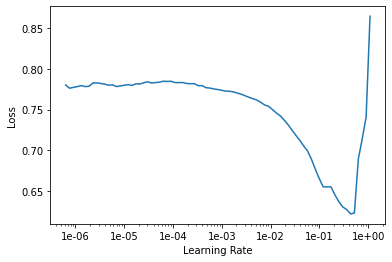

In [85]:
learn.lr_find()
learn.recorder.plot()

In [86]:
lr = 5e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.210715,0.216425,0.918743,00:53
1,0.233338,0.212296,0.920340,00:57
2,0.230572,0.215729,0.919707,00:57
3,0.214246,0.310232,0.921364,00:54
4,0.198870,2.126107,0.921786,00:52


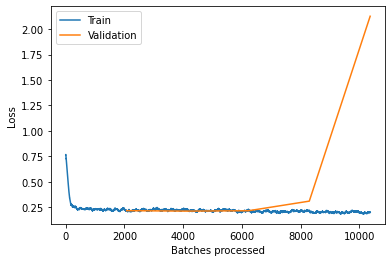

In [87]:
learn.recorder.plot_losses()

In [88]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

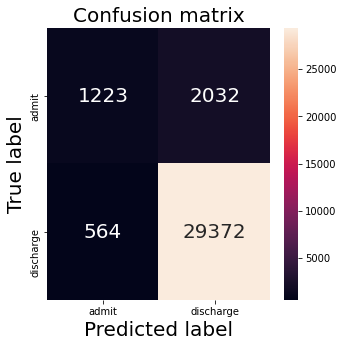

In [89]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [90]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)
print ('admission sens: ', rec[0])
print ('admission spec: ', rec[1])


weighted f1:  0.911335774303672
f1:           [0.485125 0.957679]
accuracy:     0.9217860263324396
precision:    [0.684387 0.935295]
recall:       [0.37573 0.98116]
admission sens:  0.3757296466973886
admission spec:  0.9811598075895244


In [ ]:
results_df = pd.DataFrame([experiment_desc, layers, epochs, f1_w, f1, acc, prec, rec, rec[0], rec[1]]).T
results_df.columns = ['description', 'layers', 'epochs','weighted f1', 'f1', 'accuracy', 'precision', 'recall', 'admission sensitivity', 'admission specificity']

##### experiment 2 - deeper network

In [ ]:
#hyperparameters
experiment_desc = 'whole dataset'
layers = [200,100, 50]
epochs = 5
columns = 'all'


In [ ]:
#f1 = FBeta(beta=1, average = 'weighted')

learn = tabular_learner(data, layers=layers, metrics=[accuracy])


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


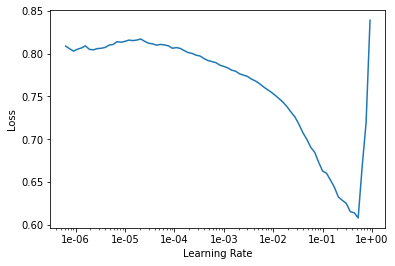

In [94]:
learn.lr_find()
learn.recorder.plot()

In [95]:
lr = 5e-2
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.226848,11.833688,0.917267,00:59
1,0.217146,2788.790283,0.919556,01:04
2,0.220541,0.949662,0.919978,01:05
3,0.231423,0.207786,0.920732,01:04
4,0.203191,0.206240,0.921334,01:03


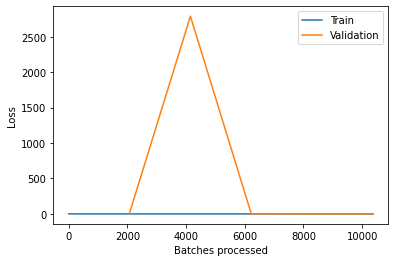

In [96]:
learn.recorder.plot_losses()

In [97]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

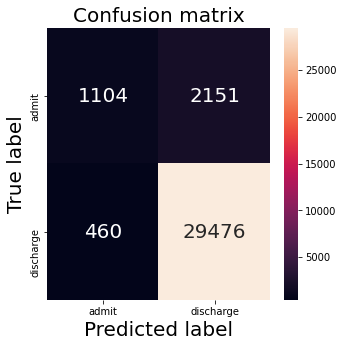

In [98]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [99]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1:    ', f1_w)
print ('f1:             ', f1)
print ('accuracy:       ', acc)
print ('precision:      ', prec)
print ('recall:         ', rec)
print ('admission sens: ', rec[0])
print ('admission spec: ', rec[1])


weighted f1:     0.9086124480903628
f1:              [0.458186 0.957588]
accuracy:        0.9213340965924498
precision:       [0.705882 0.931988]
recall:          [0.339171 0.984634]
admission sens:  0.3391705069124424
admission spec:  0.9846338856226616


In [ ]:
results_df.loc[len(results_df)] = [experiment_desc, layers, epochs, f1_w, f1, acc, prec, rec, rec[0], rec[1]]

##### experiment 3 - even deeper network

In [ ]:
#hyperparameters
experiment_desc = 'whole dataset'
layers = [400,200,100, 50]
epochs = 5
columns = 'all'


In [ ]:
#f1 = FBeta(beta=1, average = 'weighted')

learn = tabular_learner(data, layers=layers, metrics=[accuracy])


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


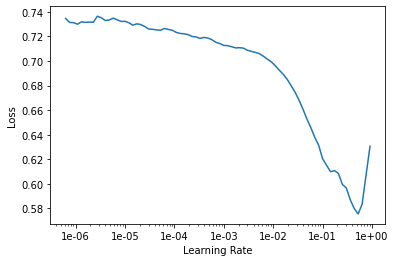

In [103]:
learn.lr_find()
learn.recorder.plot()

In [104]:
lr = 5e-2
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.229014,5437522.500000,0.915821,01:12
1,0.223398,0.212135,0.920732,01:17
2,0.230548,0.207907,0.921274,01:18
3,0.204521,0.207694,0.920008,01:16
4,0.196030,0.205652,0.922117,01:16


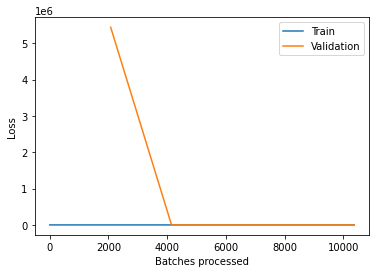

In [105]:
learn.recorder.plot_losses()

In [106]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

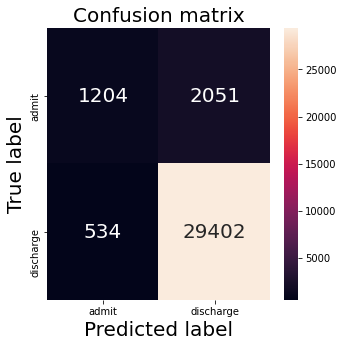

In [107]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [108]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)
print ('admission sens: ', rec[0])
print ('admission spec: ', rec[1])


weighted f1:  0.9112483818279425
f1:           [0.482275 0.957891]
accuracy:     0.9221174414750987
precision:    [0.69275  0.934792]
recall:       [0.369892 0.982162]
admission sens:  0.36989247311827955
admission spec:  0.9821619454836985


In [ ]:
results_df.loc[len(results_df)] = [experiment_desc, layers, epochs, f1_w, f1, acc, prec, rec, rec[0], rec[1]]

##### experiment 4 - same network as exp 3, more epochs

In [ ]:
#hyperparameters
experiment_desc = 'whole dataset'
layers = [400,200,100, 50]
epochs = 10
columns = 'all'


In [ ]:
#f1 = FBeta(beta=1, average = 'weighted')

learn = tabular_learner(data, layers=layers, metrics=[accuracy])


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


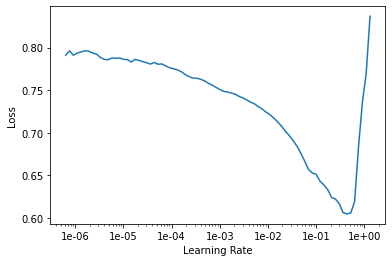

In [112]:
learn.lr_find()
learn.recorder.plot()

In [113]:
lr = 5e-2
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.224520,0.218617,0.915730,01:11
1,0.219154,0.215647,0.916755,01:15
2,0.215760,2336.280762,0.870266,01:17
3,0.219510,0.225717,0.913501,01:17
4,0.209234,0.215065,0.917448,01:18
5,0.212383,47.082230,0.920882,01:18
6,0.212697,0.213149,0.916363,01:18
7,0.205583,0.210827,0.920340,01:18
8,0.198628,0.206018,0.921214,01:17
9,0.199186,0.206509,0.921575,01:18


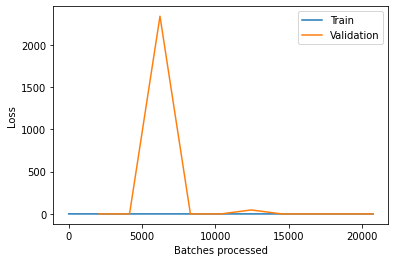

In [114]:
learn.recorder.plot_losses()

In [115]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

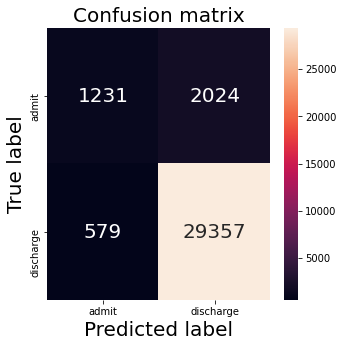

In [116]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [117]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)
print ('admission sens: ', rec[0])
print ('admission spec: ', rec[1])


weighted f1:  0.9113122445736702
f1:           [0.486081 0.957548]
accuracy:     0.921575125787111
precision:    [0.68011  0.935502]
recall:       [0.378187 0.980659]
admission sens:  0.3781874039938556
admission spec:  0.9806587386424372


In [ ]:
results_df.loc[len(results_df)] = [experiment_desc, layers, epochs, f1_w, f1, acc, prec, rec, rec[0], rec[1]]

##### experiment 5 - same as above but with lower lr

In [ ]:
#hyperparameters
experiment_desc = 'whole dataset'
layers = [400,200,100, 50]
epochs = 10
columns = 'all'


In [ ]:
#f1 = FBeta(beta=1, average = 'weighted')

learn = tabular_learner(data, layers=layers, metrics=[accuracy])


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


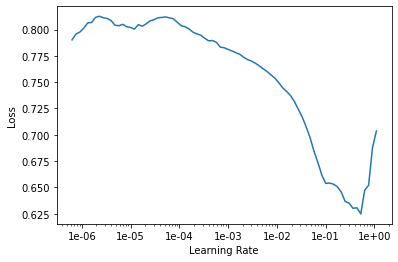

In [121]:
learn.lr_find()
learn.recorder.plot()

In [122]:
lr = 1e-3
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.245106,0.230770,0.914977,01:13
1,0.209211,0.213728,0.918713,01:15
2,0.214744,0.209197,0.920430,01:17
3,0.207431,0.208774,0.920822,01:18
4,0.203799,0.208414,0.920641,01:18
5,0.211767,0.208933,0.921937,01:17
6,0.184230,0.207159,0.921696,01:16
7,0.189343,0.207819,0.921123,01:16
8,0.192755,0.208775,0.920942,01:14
9,0.174976,0.209136,0.921304,01:14


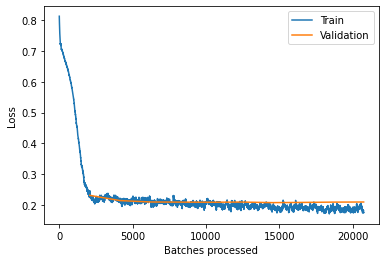

In [123]:
learn.recorder.plot_losses()

In [124]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

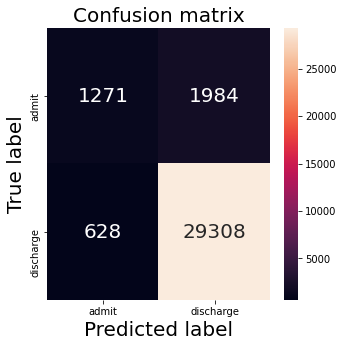

In [125]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [126]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)
print ('admission sens: ', rec[0])
print ('admission spec: ', rec[1])


weighted f1:  0.9118230676626863
f1:           [0.493209 0.95734 ]
accuracy:     0.9213039679431171
precision:    [0.6693   0.936597]
recall:       [0.390476 0.979022]
admission sens:  0.3904761904761905
admission spec:  0.979021913415286


In [ ]:
results_df.loc[len(results_df)] = [experiment_desc, layers, epochs, f1_w, f1, acc, prec, rec, rec[0], rec[1]]

In [ ]:
results_df.to_csv('tabular_data_results.csv', index = False)

In [129]:
results_df

,description,layers,epochs,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,whole dataset,"[100, 50]",5,0.911336,"[0.4851249504165014, 0.9576785132050863]",0.921786,"[0.6843872411863459, 0.9352948668959368]","[0.3757296466973886, 0.9811598075895244]",0.37573,0.98116
1,whole dataset,"[200, 100, 50]",5,0.908612,"[0.45818634571487865, 0.9575881617205139]",0.921334,"[0.7058823529411765, 0.9319884908464287]","[0.3391705069124424, 0.9846338856226616]",0.339171,0.984634
2,whole dataset,"[400, 200, 100, 50]",5,0.911248,"[0.48227518525936314, 0.9578914789294499]",0.922117,"[0.6927502876869965, 0.9347915938066321]","[0.36989247311827955, 0.9821619454836985]",0.369892,0.982162
3,whole dataset,"[400, 200, 100, 50]",10,0.911312,"[0.48608094768015797, 0.9575484775837044]",0.921575,"[0.6801104972375691, 0.9355023740479909]","[0.3781874039938556, 0.9806587386424372]",0.378187,0.980659
4,whole dataset,"[400, 200, 100, 50]",10,0.911823,"[0.493209157935584, 0.9573397791859933]",0.921304,"[0.6692996313849394, 0.9365972133452639]","[0.3904761904761905, 0.979021913415286]",0.390476,0.979022


In [ ]:
#hyperparameters
experiment_desc = 'whole dataset'
layers = [400,200,100, 50]
epochs = 15
columns = 'all'


In [ ]:
#f1 = FBeta(beta=1, average = 'weighted')

learn = tabular_learner(data, layers=layers, metrics=[accuracy])


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


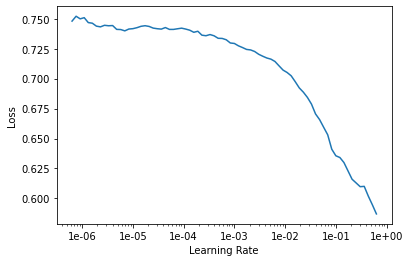

In [132]:
learn.lr_find()
learn.recorder.plot()

In [133]:
lr = 1e-3
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.271118,0.261029,0.916965,01:12
1,0.211239,0.212284,0.918954,01:14
2,0.204897,0.210593,0.918984,01:15
3,0.210991,0.207902,0.920370,01:18
4,0.197278,0.210198,0.918412,01:17
5,0.213021,0.207602,0.921937,01:17
6,0.200895,0.207777,0.920942,01:17
7,0.196132,0.207517,0.921153,01:17
8,0.193439,0.208038,0.921244,01:17
9,0.193509,0.209511,0.921485,01:17


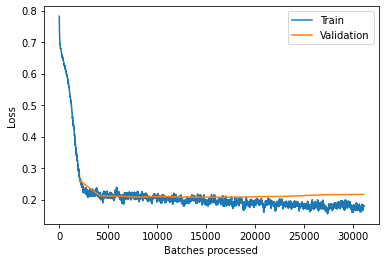

In [134]:
learn.recorder.plot_losses()

In [135]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

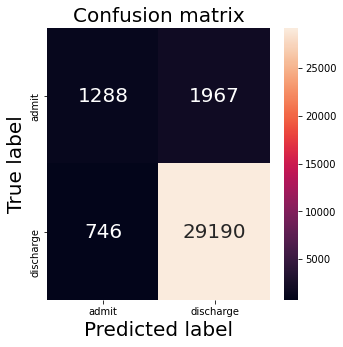

In [136]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [137]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)
print ('admission sens: ', rec[0])
print ('admission spec: ', rec[1])


weighted f1:  0.9096427968348605
f1:           [0.487049 0.955592]
accuracy:     0.9182609743605195
precision:    [0.633235 0.936868]
recall:       [0.395699 0.97508 ]
admission sens:  0.3956989247311828
admission spec:  0.975080171031534


In [ ]:
results_df.loc[len(results_df)] = [experiment_desc, layers, epochs, f1_w, f1, acc, prec, rec, rec[0], rec[1]]

In [ ]:
results_df.to_csv('tabular_data_results.csv', index = False)

In [140]:
results_df

,description,layers,epochs,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,whole dataset,"[100, 50]",5,0.911336,"[0.4851249504165014, 0.9576785132050863]",0.921786,"[0.6843872411863459, 0.9352948668959368]","[0.3757296466973886, 0.9811598075895244]",0.37573,0.98116
1,whole dataset,"[200, 100, 50]",5,0.908612,"[0.45818634571487865, 0.9575881617205139]",0.921334,"[0.7058823529411765, 0.9319884908464287]","[0.3391705069124424, 0.9846338856226616]",0.339171,0.984634
2,whole dataset,"[400, 200, 100, 50]",5,0.911248,"[0.48227518525936314, 0.9578914789294499]",0.922117,"[0.6927502876869965, 0.9347915938066321]","[0.36989247311827955, 0.9821619454836985]",0.369892,0.982162
3,whole dataset,"[400, 200, 100, 50]",10,0.911312,"[0.48608094768015797, 0.9575484775837044]",0.921575,"[0.6801104972375691, 0.9355023740479909]","[0.3781874039938556, 0.9806587386424372]",0.378187,0.980659
4,whole dataset,"[400, 200, 100, 50]",10,0.911823,"[0.493209157935584, 0.9573397791859933]",0.921304,"[0.6692996313849394, 0.9365972133452639]","[0.3904761904761905, 0.979021913415286]",0.390476,0.979022
5,whole dataset,"[400, 200, 100, 50]",15,0.909643,"[0.48704859141614665, 0.9555922937161377]",0.918261,"[0.6332350049164208, 0.9368681195237025]","[0.3956989247311828, 0.975080171031534]",0.395699,0.97508


In [ ]:
results_df.to_csv(path + '/tabular_data_results.csv', index = False)

In [ ]:
clin = pd.read_csv('/content/drive/My Drive/ML_data/balanced_admit_dc_combo_data.csv', index_col = 0,low_memory = False)

In [ ]:
date_columns = ['Triage Date & Time', 'Reg Date & Time']
for col in date_columns:
    add_datepart(clin, col, drop = False, time = True)
    add_cyclic_datepart(clin, col, time = True)

In [ ]:
clin.shape

(32758, 121)

In [ ]:
cat_names =[
 'Triage Date & TimeIs_month_end',
 'Triage Date & TimeIs_month_start',
 'Triage Date & TimeIs_quarter_end',
 'Triage Date & TimeIs_quarter_start',
 'Triage Date & TimeIs_year_end',
 'Triage Date & TimeIs_year_start',
 'Reg Date & TimeIs_month_end',
 'Reg Date & TimeIs_month_start',
 'Reg Date & TimeIs_quarter_end',
 'Reg Date & TimeIs_quarter_start',
 'Reg Date & TimeIs_year_end',
 'Reg Date & TimeIs_year_start',
 'GenderDesc',
 'PresentingComplaintDesc',
 'MainDiagnosisCodeDesc',
 'Are you feeling feverish or have had shakes or chills in the last 24 hours?',
 'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
 'Do you have a new Rash?',
 'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
 'Have you travelled outside of Canada/USA in the last 3 weeks?',
 'Have you had contact with a sick person who has travelled outside of Canada/USA in the last 3 weeks?',
 'Have you received Health Care in another country in the last 2 years?',
 'Do you have a new/worse cough or shortness of breath?',
 'If so, select all countries that apply',
 'If so, select all infectious diseases that apply'
]


In [ ]:
cont_names = [
 'AgeNumber',
 'Triage Date & TimeYear',
 'Triage Date & TimeMonth',
 'Triage Date & TimeWeek',
 'Triage Date & TimeDay',
 'Triage Date & TimeDayofweek',
 'Triage Date & TimeDayofyear',
 'Triage Date & TimeHour',
 'Triage Date & TimeMinute',
 'Triage Date & TimeSecond',
 'Triage Date & TimeElapsed',
 'Reg Date & TimeYear',
 'Reg Date & TimeMonth',
 'Reg Date & TimeWeek',
 'Reg Date & TimeDay',
 'Reg Date & TimeDayofweek',
 'Reg Date & TimeDayofyear',
 'Reg Date & TimeHour',
 'Reg Date & TimeMinute',
 'Reg Date & TimeSecond',
 'Reg Date & TimeElapsed',
 'num_comorbids']

In [ ]:

procs = [FillMissing, Categorify, Normalize]

In [ ]:
test = TabularList.from_df(clin.copy(),cat_names=cat_names, cont_names=cont_names)

In [ ]:
valid_idxs = random.sample(range(len(clin)), len(clin)//5)

In [ ]:
len(test), len(valid_idxs)

(32758, 6551)

In [ ]:
dep_var = 'discharge'  

data = (TabularList.from_df(clin, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idxs)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [ ]:
data.save(path + '/tabulardb')

In [ ]:
#f1 = FBeta(beta=1, average = 'weighted')

learn = tabular_learner(data, layers=[200,100], metrics=[accuracy])


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


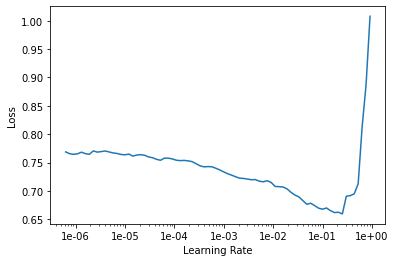

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.356489,0.431890,0.811021,00:08
1,0.350106,0.432528,0.807816,00:08
2,0.356679,0.432999,0.809189,00:08
3,0.350061,0.434635,0.809189,00:08
4,0.351976,0.437307,0.812242,00:08
5,0.342573,0.443178,0.805068,00:08
6,0.344181,0.438542,0.806900,00:08
7,0.333394,0.443989,0.808274,00:08
8,0.342947,0.445694,0.808426,00:08
9,0.325650,0.446917,0.807205,00:08


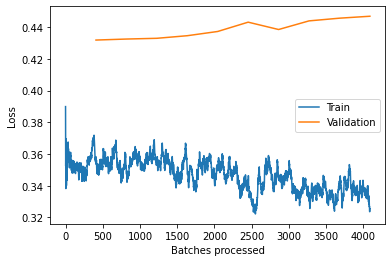

In [ ]:
learn.recorder.plot_losses()

In [ ]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

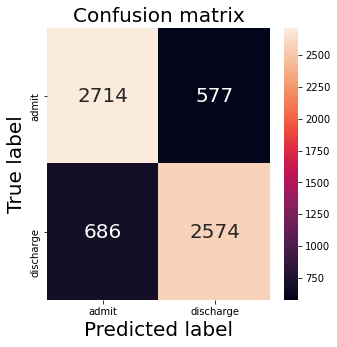

In [ ]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [ ]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)


weighted f1:  0.8071364211845805
f1:           [0.811239 0.802995]
accuracy:     0.8072050068691803
precision:    [0.798235 0.816884]
recall:       [0.824673 0.789571]


#### now gonna try again with a different target - ICU vs other

In [ ]:
dep_var = 'target5'

test = TabularList.from_df(clin.copy(),cat_names=cat_names, cont_names=cont_names)

valid_idxs = random.sample(range(len(clin)), len(clin)//5)

data = (TabularList.from_df(clin, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idxs)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

learn2 = tabular_learner(data, layers=[200,100], metrics=[accuracy])

In [ ]:
learn2.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.009135,0.010627,0.998439,00:23
1,0.013064,0.010234,0.998439,00:23
2,0.010707,0.009592,0.998439,00:23
3,0.007843,0.062234,0.998439,00:23
4,0.006302,0.010187,0.998439,00:23


In [ ]:
preds, targets = learn2.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

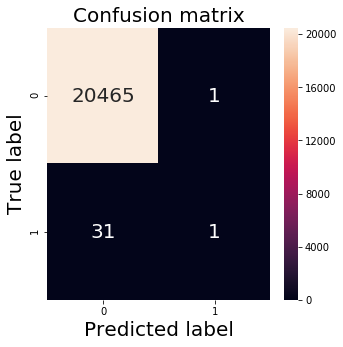

In [ ]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [ ]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)


weighted f1:  0.9977507108556443
f1:           [0.999219 0.058824]
accuracy:     0.9984388720850814
precision:    [0.998488 0.5     ]
recall:       [0.999951 0.03125 ]


In [ ]:
clin = pd.read_csv(data_path + '/100kcompleterecords.csv')

In [ ]:
dep_var = 'service'

test = TabularList.from_df(clin.copy(),cat_names=cat_names, cont_names=cont_names)

valid_idxs = random.sample(range(len(clin)), len(clin)//5)

data = (TabularList.from_df(clin, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idxs)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())
learn3 = tabular_learner(data, layers=[200,100], metrics=[accuracy])

In [ ]:
learn3.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.247050,0.251622,0.917699,00:24
1,0.245402,0.242654,0.922041,00:24
2,0.226665,0.234371,0.924041,00:24
3,0.212135,0.232763,0.923749,00:24
4,0.206278,0.233248,0.923993,00:24


In [ ]:
preds, targets = learn3.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

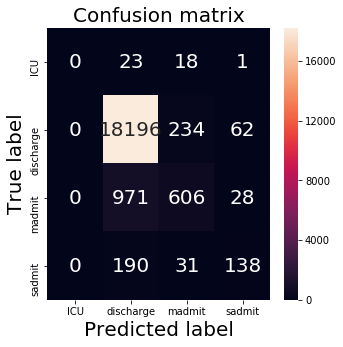

In [ ]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [ ]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)


weighted f1:  0.913154318648459
f1:           [0.       0.960921 0.485966 0.469388]
accuracy:     0.9239925846424042
precision:    [0.       0.938906 0.681665 0.60262 ]
recall:       [0.       0.983993 0.37757  0.384401]


In [ ]:
dep_var = 'outcome'

test = TabularList.from_df(clin.copy(),cat_names=cat_names, cont_names=cont_names)

valid_idxs = random.sample(range(len(clin)), len(clin)//5)

data = (TabularList.from_df(clin, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idxs)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())
learn4 = tabular_learner(data, layers=[200,100], metrics=[accuracy])

In [ ]:
learn4.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.259874,0.245116,0.922090,00:23
1,0.243131,0.235890,0.922871,00:24
2,0.220609,0.242940,0.923310,00:23
3,0.218350,0.266943,0.922431,00:24
4,0.204541,0.264989,0.923651,00:23


In [ ]:
preds, targets = learn4.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

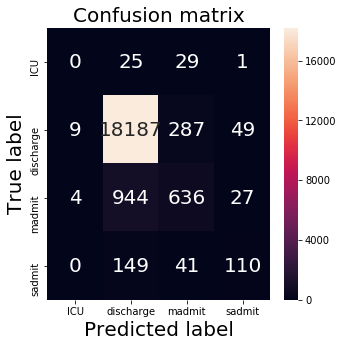

In [ ]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [ ]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)


weighted f1:  0.9141334793413808
f1:           [0.       0.961334 0.488479 0.451745]
accuracy:     0.9236510879110157
precision:    [0.       0.942088 0.640483 0.588235]
recall:       [0.       0.981384 0.394786 0.366667]
